<a href="https://colab.research.google.com/github/Venkat-Ramana-G/24MAI0091-Data-Pipeline-for-Customer-Feedback-Analysis/blob/main/templates/aistudio_gemini_prompt_freeform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2023 Google LLC

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

In [1]:
!pip install -U -q "google-generativeai>=0.8.2"

In [3]:
# import necessary modules.
import base64
import copy
import json
import pathlib
import requests


import PIL.Image
import IPython.display
from IPython.display import Markdown

try:
    # The SDK will automatically read it from the GOOGLE_API_KEY environment variable.
    # In Colab get the key from Colab-secrets ("🔑" in the left panel).
    import os
    from google.colab import userdata

    os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
except ImportError:
    pass

import google.generativeai as genai

# Parse the arguments

model = 'gemini-2.0-flash-exp' # @param {isTemplate: true}
contents_b64 = 'W3sicm9sZSI6InVzZXIiLCJwYXJ0cyI6W3sidGV4dCI6IlNlbnRpbWVudCBBbmFseXNpcyBvbiBNb3ZpZSBSZXZpZXdzIHRvIGNhdGVnb3JpemUgaW50byBwb3N0aXZlIG5lZ2F0aXZlIGFuZCBuZXV0cmFsIFxcbiJ9XX0seyJyb2xlIjoibW9kZWwiLCJwYXJ0cyI6W3sidGV4dCI6Ik9rYXksIGxldCdzIGJyZWFrIGRvd24gaG93IHRvIHBlcmZvcm0gc2VudGltZW50IGFuYWx5c2lzIG9uIG1vdmllIHJldmlld3MgdG8gY2F0ZWdvcml6ZSB0aGVtIGludG8gcG9zaXRpdmUsIG5lZ2F0aXZlLCBhbmQgbmV1dHJhbC4gVGhpcyBpcyBhIGNsYXNzaWMgTmF0dXJhbCBMYW5ndWFnZSBQcm9jZXNzaW5nIChOTFApIHRhc2suIEhlcmUncyBhIGNvbXByZWhlbnNpdmUgZ3VpZGU6XFxuXFxuKioxLiBVbmRlcnN0YW5kaW5nIHRoZSBQcm9ibGVtKipcXG5cXG4qICoqU2VudGltZW50IEFuYWx5c2lzOioqIFRoZSBwcm9jZXNzIG9mIGNvbXB1dGF0aW9uYWxseSBkZXRlcm1pbmluZyB0aGUgZW1vdGlvbmFsIHRvbmUgZXhwcmVzc2VkIGluIGEgcGllY2Ugb2YgdGV4dC4gSW4gdGhpcyBjYXNlLCB3ZSdyZSBsb29raW5nIGF0IG1vdmllIHJldmlld3MuXFxuKiAqKkNhdGVnb3JpZXM6KiogV2UnbGwgY2xhc3NpZnkgcmV2aWV3cyBpbnRvIHRocmVlIGNhdGVnb3JpZXM6XFxuICAgICogKipQb3NpdGl2ZToqKiBFeHByZXNzaW5nIGZhdm9yYWJsZSBvcGluaW9ucywgZW5qb3ltZW50LCBvciBzYXRpc2ZhY3Rpb24uXFxuICAgICogKipOZWdhdGl2ZToqKiBFeHByZXNzaW5nIHVuZmF2b3JhYmxlIG9waW5pb25zLCBkaXNhcHBvaW50bWVudCwgb3IgZGlzc2F0aXNmYWN0aW9uLlxcbiAgICAqICoqTmV1dHJhbDoqKiBFeHByZXNzaW5nIG9iamVjdGl2ZSBmYWN0cyBvciBhIGxhY2sgb2Ygc3Ryb25nIHBvc2l0aXZlIG9yIG5lZ2F0aXZlIGVtb3Rpb24uXFxuKiAqKkNoYWxsZW5nZXM6KipcXG4gICAgKiAqKkFtYmlndWl0eToqKiBMYW5ndWFnZSBjYW4gYmUgdHJpY2t5LiBTYXJjYXNtLCBodW1vciwgYW5kIGRvdWJsZSBuZWdhdGl2ZXMgY2FuIGNvbmZ1c2UgYWxnb3JpdGhtcy5cXG4gICAgKiAqKkNvbnRleHQ6KiogVGhlIG1lYW5pbmcgb2Ygd29yZHMgY2FuIGNoYW5nZSBiYXNlZCBvbiB0aGVpciBzdXJyb3VuZGluZyB3b3Jkcy5cXG4gICAgKiAqKlN1YmplY3Rpdml0eToqKiBXaGF0IG9uZSBwZXJzb24gY29uc2lkZXJzIHBvc2l0aXZlIGFub3RoZXIgbWlnaHQgY29uc2lkZXIgbmV1dHJhbC5cXG5cXG4qKjIuIERhdGEgUHJlcGFyYXRpb24qKlxcblxcbiogKipEYXRhc2V0OioqIFlvdSdsbCBuZWVkIGEgZGF0YXNldCBvZiBtb3ZpZSByZXZpZXdzIGxhYmVsZWQgd2l0aCB0aGVpciBzZW50aW1lbnQgKHBvc2l0aXZlLCBuZWdhdGl2ZSwgb3IgbmV1dHJhbCkuIFBvcHVsYXIgb3B0aW9ucyBpbmNsdWRlOlxcbiAgICAqICoqSU1EYiBNb3ZpZSBSZXZpZXdzIERhdGFzZXQ6KiogV2lkZWx5IHVzZWQgYW5kIGF2YWlsYWJsZSBvbmxpbmUuXFxuICAgICogKipNb3ZpZSBSZXZpZXcgUG9sYXJpdHkgRGF0YXNldCB2Mi4wIChDb3JuZWxsKToqKiBBbm90aGVyIGNvbW1vbiBkYXRhc2V0LlxcbiAgICAqICoqQ3VzdG9tIERhdGE6KiogWW91IGNhbiBhbHNvIGNvbGxlY3QgeW91ciBvd24gcmV2aWV3cyBmcm9tIHdlYnNpdGVzIG9yIGRhdGFiYXNlcy5cXG4qICoqRGF0YSBDbGVhbmluZzoqKlxcbiAgICAqICoqUmVtb3ZlIEhUTUwgdGFnczoqKiBJZiB5b3VyIGRhdGEgaXMgd2ViLXNjcmFwZWQsIGdldCByaWQgb2YgSFRNTC5cXG4gICAgKiAqKkNvbnZlcnQgdG8gbG93ZXJjYXNlOioqIE1ha2UgYWxsIHRleHQgY29uc2lzdGVudCBmb3IgcHJvY2Vzc2luZy5cXG4gICAgKiAqKlJlbW92ZSBwdW5jdHVhdGlvbjoqKiBQdW5jdHVhdGlvbiBjYW4gYmUgbm9pc2UgZm9yIHNvbWUgbW9kZWxzLlxcbiAgICAqICoqUmVtb3ZlIHNwZWNpYWwgY2hhcmFjdGVyczoqKiBSZW1vdmUgbm9uLWFscGhhbnVtZXJpYyBjaGFyYWN0ZXJzLlxcbiAgICAqICoqSGFuZGxlIFN0b3AgV29yZHM6KiogUmVtb3ZlIGNvbW1vbiB3b3JkcyBsaWtlIFxcXCJ0aGVcXFwiLCBcXFwiYVxcXCIsIFxcXCJpc1xcXCIgYXMgdGhleSBkb24ndCBvZnRlbiBjYXJyeSBzZW50aW1lbnQuXFxuICAgICogKipIYW5kbGUgTnVtYmVyczoqKiBEZWNpZGUgd2hldGhlciBudW1iZXJzIGFyZSByZWxldmFudCBmb3IgeW91ciB0YXNrIChlLmcuLCByZW1vdmUgdGhlbSBpZiB0aGV5J3JlIG5vdCByYXRpbmdzKS5cXG4gICAgKiAqKlRva2VuaXphdGlvbjoqKiBTcGxpdCB0aGUgcmV2aWV3cyBpbnRvIGluZGl2aWR1YWwgd29yZHMgb3Igc3ViLXdvcmRzICh0b2tlbnMpLlxcbiAgICAqICoqU3RlbW1pbmcvTGVtbWF0aXphdGlvbjoqKiBSZWR1Y2Ugd29yZHMgdG8gdGhlaXIgcm9vdCBmb3JtIChlLmcuLCBcXFwicnVubmluZ1xcXCIgLT4gXFxcInJ1blxcXCIpLiBUaGlzIGlzIGhlbHBmdWwgdG8gZ3JvdXAgc2ltaWxhciB3b3Jkcy5cXG5cXG4qKjMuIEZlYXR1cmUgRW5naW5lZXJpbmcqKlxcblxcbiogKipCYWcgb2YgV29yZHMgKEJvVyk6KipcXG4gICAgKiBDcmVhdGUgYSB2b2NhYnVsYXJ5IG9mIGFsbCB1bmlxdWUgd29yZHMgaW4gdGhlIGRhdGFzZXQuXFxuICAgICogUmVwcmVzZW50IGVhY2ggcmV2aWV3IGFzIGEgdmVjdG9yLCB3aGVyZSBlYWNoIGVsZW1lbnQgY29ycmVzcG9uZHMgdG8gdGhlIGZyZXF1ZW5jeSBvZiBhIHdvcmQgaW4gdGhlIHJldmlldy5cXG4qICoqVEYtSURGIChUZXJtIEZyZXF1ZW5jeS1JbnZlcnNlIERvY3VtZW50IEZyZXF1ZW5jeSk6KipcXG4gICAgKiBTaW1pbGFyIHRvIEJvVywgYnV0IGl0IHdlaWdocyB3b3JkcyBiYXNlZCBvbiB0aGVpciBpbXBvcnRhbmNlIGluIHRoZSBkb2N1bWVudCBhbmQgdGhlIHdob2xlIGNvcnB1cy5cXG4gICAgKiBXb3JkcyB0aGF0IGFwcGVhciBmcmVxdWVudGx5IGluIGEgc3BlY2lmaWMgcmV2aWV3IGJ1dCByYXJlbHkgaW4gb3RoZXIgcmV2aWV3cyBhcmUgZ2l2ZW4gbW9yZSB3ZWlnaHQuXFxuKiAqKldvcmQgRW1iZWRkaW5ncyAoV29yZDJWZWMsIEdsb1ZlLCBGYXN0VGV4dCk6KipcXG4gICAgKiBNYXAgd29yZHMgdG8gZGVuc2UgdmVjdG9ycyB0aGF0IGNhcHR1cmUgc2VtYW50aWMgcmVsYXRpb25zaGlwcyBiZXR3ZWVuIHdvcmRzLlxcbiAgICAqIFRoZXNlIGVtYmVkZGluZ3MgYXJlIG9mdGVuIHByZS10cmFpbmVkIG9uIGxhcmdlIHRleHQgZGF0YXNldHMuXFxuXFxuKio0LiBNb2RlbCBTZWxlY3Rpb24qKlxcblxcbiogKipNYWNoaW5lIExlYXJuaW5nIE1vZGVsczoqKlxcbiAgICAqICoqTmFpdmUgQmF5ZXM6KiogU2ltcGxlIGFuZCBmYXN0LCBvZnRlbiBhIGdvb2QgYmFzZWxpbmUuXFxuICAgICogKipMb2dpc3RpYyBSZWdyZXNzaW9uOioqIEdvb2QgZm9yIGxpbmVhciBzZXBhcmFiaWxpdHksIGFub3RoZXIgZ29vZCBzdGFydGluZyBwb2ludC5cXG4gICAgKiAqKlN1cHBvcnQgVmVjdG9yIE1hY2hpbmVzIChTVk0pOioqIEVmZmVjdGl2ZSBmb3IgaGlnaC1kaW1lbnNpb25hbCBkYXRhLlxcbiAgICAqICoqUmFuZG9tIEZvcmVzdCAmIEdyYWRpZW50IEJvb3N0aW5nOioqIFBvd2VyZnVsIGVuc2VtYmxlIG1ldGhvZHMgdGhhdCBvZnRlbiB5aWVsZCBnb29kIHJlc3VsdHMuXFxuKiAqKkRlZXAgTGVhcm5pbmcgTW9kZWxzOioqXFxuICAgICogKipSZWN1cnJlbnQgTmV1cmFsIE5ldHdvcmtzIChSTk5zKSBsaWtlIExTVE1zIGFuZCBHUlVzOioqIEdvb2QgYXQgY2FwdHVyaW5nIHNlcXVlbnRpYWwgaW5mb3JtYXRpb24gaW4gdGhlIHRleHQuXFxuICAgICogKipDb252b2x1dGlvbmFsIE5ldXJhbCBOZXR3b3JrcyAoQ05Ocyk6KiogRWZmZWN0aXZlIGF0IGNhcHR1cmluZyBsb2NhbCBwYXR0ZXJucyBpbiB0aGUgdGV4dC5cXG4gICAgKiAqKlRyYW5zZm9ybWVyIE5ldHdvcmtzIChCRVJULCBSb0JFUlRhKToqKiBQb3dlcmZ1bCBwcmUtdHJhaW5lZCBtb2RlbHMgdGhhdCBhY2hpZXZlIHN0YXRlLW9mLXRoZS1hcnQgcmVzdWx0cy5cXG5cXG4qKjUuIFRyYWluaW5nIGFuZCBFdmFsdWF0aW9uKipcXG5cXG4qICoqU3BsaXQgRGF0YToqKiBTcGxpdCB5b3VyIGRhdGFzZXQgaW50byB0cmFpbmluZywgdmFsaWRhdGlvbiwgYW5kIHRlc3Qgc2V0cy5cXG4qICoqVHJhaW4gTW9kZWw6KiogVHJhaW4geW91ciBjaG9zZW4gbW9kZWwgb24gdGhlIHRyYWluaW5nIGRhdGEuXFxuKiAqKkh5cGVycGFyYW1ldGVyIFR1bmluZzoqKiBBZGp1c3QgbW9kZWwgcGFyYW1ldGVycyB1c2luZyB0aGUgdmFsaWRhdGlvbiBzZXQgdG8gb3B0aW1pemUgcGVyZm9ybWFuY2UuXFxuKiAqKkV2YWx1YXRpb24gTWV0cmljczoqKlxcbiAgICAqICoqQWNjdXJhY3k6KiogUGVyY2VudGFnZSBvZiBjb3JyZWN0bHkgY2xhc3NpZmllZCByZXZpZXdzLlxcbiAgICAqICoqUHJlY2lzaW9uOioqIE9mIGFsbCB0aGUgcmV2aWV3cyBwcmVkaWN0ZWQgYXMgcG9zaXRpdmUsIGhvdyBtYW55IHdlcmUgYWN0dWFsbHkgcG9zaXRpdmU/IChhbmQgdmljZS12ZXJzYSBmb3IgbmVnYXRpdmUpLlxcbiAgICAqICoqUmVjYWxsOioqIE9mIGFsbCB0aGUgYWN0dWFsIHBvc2l0aXZlIHJldmlld3MsIGhvdyBtYW55IHdlcmUgcHJlZGljdGVkIGFzIHBvc2l0aXZlPyAoYW5kIHZpY2UtdmVyc2EgZm9yIG5lZ2F0aXZlKS5cXG4gICAgKiAqKkYxLXNjb3JlOioqIFRoZSBoYXJtb25pYyBtZWFuIG9mIHByZWNpc2lvbiBhbmQgcmVjYWxsLlxcbiAgICAqICoqQ29uZnVzaW9uIE1hdHJpeDoqKiBBIHRhYmxlIHNob3dpbmcgdGhlIHRydWUgdnMuIHByZWRpY3RlZCBjbGFzc2lmaWNhdGlvbnMsIHVzZWZ1bCBmb3IgaWRlbnRpZnlpbmcgd2hlcmUgdGhlIG1vZGVsIG1ha2VzIGVycm9ycy5cXG4qICoqQ3Jvc3MtdmFsaWRhdGlvbjoqKiBVc2UgY3Jvc3MtdmFsaWRhdGlvbiB0byBnZXQgbW9yZSByb2J1c3QgZXN0aW1hdGVzIG9mIHBlcmZvcm1hbmNlLlxcblxcbioqNi4gSW1wbGVtZW50YXRpb24gRXhhbXBsZSAoUHl0aG9uIHdpdGggU2Npa2l0LWxlYXJuIGFuZCBOTFRLKSoqXFxuXFxuYGBgcHl0aG9uXFxuaW1wb3J0IG5sdGtcXG5pbXBvcnQgcmVcXG5mcm9tIG5sdGsuY29ycHVzIGltcG9ydCBzdG9wd29yZHNcXG5mcm9tIG5sdGsuc3RlbSBpbXBvcnQgV29yZE5ldExlbW1hdGl6ZXJcXG5mcm9tIHNrbGVhcm4ubW9kZWxfc2VsZWN0aW9uIGltcG9ydCB0cmFpbl90ZXN0X3NwbGl0XFxuZnJvbSBza2xlYXJuLmZlYXR1cmVfZXh0cmFjdGlvbi50ZXh0IGltcG9ydCBUZmlkZlZlY3Rvcml6ZXJcXG5mcm9tIHNrbGVhcm4ubGluZWFyX21vZGVsIGltcG9ydCBMb2dpc3RpY1JlZ3Jlc3Npb25cXG5mcm9tIHNrbGVhcm4ubWV0cmljcyBpbXBvcnQgYWNjdXJhY3lfc2NvcmUsIGNsYXNzaWZpY2F0aW9uX3JlcG9ydFxcbmZyb20gc2tsZWFybi5waXBlbGluZSBpbXBvcnQgUGlwZWxpbmVcXG5mcm9tIHNrbGVhcm4ucHJlcHJvY2Vzc2luZyBpbXBvcnQgTGFiZWxFbmNvZGVyXFxuXFxubmx0ay5kb3dubG9hZCgnc3RvcHdvcmRzJylcXG5ubHRrLmRvd25sb2FkKCd3b3JkbmV0JylcXG5cXG4jIFNhbXBsZSBtb3ZpZSByZXZpZXcgZGF0YSAocmVwbGFjZSB3aXRoIHlvdXIgZGF0YXNldClcXG5kYXRhID0gW1xcbiAgICAoXFxcIlRoaXMgbW92aWUgd2FzIGFtYXppbmchIEkgbG92ZWQgaXQuXFxcIiwgXFxcInBvc2l0aXZlXFxcIiksXFxuICAgIChcXFwiVGhlIHdvcnN0IGZpbG0gSSBoYXZlIGV2ZXIgc2Vlbi5cXFwiLCBcXFwibmVnYXRpdmVcXFwiKSxcXG4gICAgKFxcXCJJdCB3YXMgb2theSwgbm90aGluZyBzcGVjaWFsLlxcXCIsIFxcXCJuZXV0cmFsXFxcIiksXFxuICAgIChcXFwiVGhlIGFjdGluZyB3YXMgc3VwZXJiIGFuZCB0aGUgc3RvcnkgZ3JpcHBpbmcuXFxcIiwgXFxcInBvc2l0aXZlXFxcIiksXFxuICAgIChcXFwiVG90YWxseSBkaXNhcHBvaW50ZWQgd2l0aCB0aGUgcGxvdCBhbmQgZGlyZWN0aW9uLlxcXCIsIFxcXCJuZWdhdGl2ZVxcXCIpLFxcbiAgICAoXFxcIkkgZm91bmQgaXQgcXVpdGUgYm9yaW5nIGFuZCBwcmVkaWN0YWJsZS5cXFwiLCBcXFwibmVnYXRpdmVcXFwiKSxcXG4gICAgKFxcXCJBIGRlY2VudCBtb3ZpZSB0byBwYXNzIHRpbWUuXFxcIiwgXFxcIm5ldXRyYWxcXFwiKSxcXG4gICAgKFxcXCJUaGlzIG1vdmllIGlzIHRoZSBiZXN0IHRoaW5nIGV2ZXIhIEhpZ2hseSByZWNvbW1lbmQuXFxcIiwgXFxcInBvc2l0aXZlXFxcIiksXFxuICAgIChcXFwiVXR0ZXIgZ2FyYmFnZSEgQXZvaWQgaXQgYXQgYWxsIGNvc3RzLlxcXCIsIFxcXCJuZWdhdGl2ZVxcXCIpLFxcbiAgICAoXFxcIkl0IHdhcyBhbiBhdmVyYWdlIGZpbG0uIE5vdCBiYWQsIG5vdCBncmVhdC5cXFwiLCBcXFwibmV1dHJhbFxcXCIpLFxcbl1cXG5cXG5yZXZpZXdzLCBzZW50aW1lbnRzID0gemlwKCpkYXRhKVxcblxcbiMgMS4gUHJlcHJvY2Vzc2luZ1xcbmRlZiBwcmVwcm9jZXNzX3RleHQodGV4dCk6XFxuICAgIHRleHQgPSB0ZXh0Lmxvd2VyKCkgIyBMb3dlcmNhc2luZ1xcbiAgICB0ZXh0ID0gcmUuc3ViKHInW15hLXpcXFxcc10nLCAnJywgdGV4dCkgIyBSZW1vdmUgc3BlY2lhbCBjaGFyYWN0ZXJzIGFuZCBwdW5jdHVhdGlvblxcbiAgICB3b3JkcyA9IHRleHQuc3BsaXQoKSAjIFRva2VuaXplXFxuICAgIHN0b3Bfd29yZHMgPSBzZXQoc3RvcHdvcmRzLndvcmRzKCdlbmdsaXNoJykpXFxuICAgIHdvcmRzID0gW3dvcmQgZm9yIHdvcmQgaW4gd29yZHMgaWYgd29yZCBub3QgaW4gc3RvcF93b3Jkc10gIyBTdG9wIHdvcmQgcmVtb3ZhbFxcbiAgICBsZW1tYXRpemVyID0gV29yZE5ldExlbW1hdGl6ZXIoKVxcbiAgICB3b3JkcyA9IFtsZW1tYXRpemVyLmxlbW1hdGl6ZSh3b3JkKSBmb3Igd29yZCBpbiB3b3Jkc10gIyBMZW1tYXRpemF0aW9uXFxuICAgIHJldHVybiBcXFwiIFxcXCIuam9pbih3b3JkcylcXG5cXG5wcm9jZXNzZWRfcmV2aWV3cyA9IFtwcmVwcm9jZXNzX3RleHQocmV2aWV3KSBmb3IgcmV2aWV3IGluIHJldmlld3NdXFxuXFxuIyAyLiBGZWF0dXJlIEVuZ2luZWVyaW5nIGFuZCBNb2RlbCBUcmFpbmluZ1xcbiMgVHJhbnNmb3JtIHRhcmdldCB2YXJpYWJsZSB0byBudW1lcmljYWwgbGFiZWxzXFxubGFiZWxfZW5jb2RlciA9IExhYmVsRW5jb2RlcigpXFxuc2VudGltZW50cyA9IGxhYmVsX2VuY29kZXIuZml0X3RyYW5zZm9ybShzZW50aW1lbnRzKVxcblxcbiMgU3BsaXQgZGF0YVxcblhfdHJhaW4sIFhfdGVzdCwgeV90cmFpbiwgeV90ZXN0ID0gdHJhaW5fdGVzdF9zcGxpdChwcm9jZXNzZWRfcmV2aWV3cywgc2VudGltZW50cywgdGVzdF9zaXplPTAuMiwgcmFuZG9tX3N0YXRlPTQyKVxcblxcbiMgQ3JlYXRlIHBpcGVsaW5lIHdpdGggVEYtSURGIGFuZCBMb2dpc3RpYyBSZWdyZXNzaW9uXFxucGlwZWxpbmUgPSBQaXBlbGluZShbXFxuICAgICgndGZpZGYnLCBUZmlkZlZlY3Rvcml6ZXIoKSksXFxuICAgICgnbW9kZWwnLCBMb2dpc3RpY1JlZ3Jlc3Npb24oc29sdmVyPSdsaWJsaW5lYXInLCByYW5kb21fc3RhdGU9NDIpKVxcbl0pXFxuXFxuIyBUcmFpbiB0aGUgbW9kZWxcXG5waXBlbGluZS5maXQoWF90cmFpbiwgeV90cmFpbilcXG5cXG4jIDMuIE1vZGVsIEV2YWx1YXRpb25cXG55X3ByZWQgPSBwaXBlbGluZS5wcmVkaWN0KFhfdGVzdClcXG5wcmludChmXFxcIkFjY3VyYWN5OiB7YWNjdXJhY3lfc2NvcmUoeV90ZXN0LCB5X3ByZWQpfVxcXCIpXFxucHJpbnQoY2xhc3NpZmljYXRpb25fcmVwb3J0KHlfdGVzdCwgeV9wcmVkLCB0YXJnZXRfbmFtZXMgPSBsYWJlbF9lbmNvZGVyLmNsYXNzZXNfKSlcXG5cXG4jIEV4YW1wbGUgcHJlZGljdGlvblxcbm5ld19yZXZpZXcgPSBcXFwiVGhlIG1vdmllIHdhcyBhbiBhYnNvbHV0ZSB3YXN0ZSBvZiB0aW1lLiBJIGhhdGVkIGl0LlxcXCJcXG5wcm9jZXNzZWRfbmV3X3JldmlldyA9IHByZXByb2Nlc3NfdGV4dChuZXdfcmV2aWV3KVxcbnByZWRpY3RlZF9zZW50aW1lbnQgPSBwaXBlbGluZS5wcmVkaWN0KFtwcm9jZXNzZWRfbmV3X3Jldmlld10pXFxucHJlZGljdGVkX3NlbnRpbWVudCA9IGxhYmVsX2VuY29kZXIuaW52ZXJzZV90cmFuc2Zvcm0ocHJlZGljdGVkX3NlbnRpbWVudClcXG5wcmludChmXFxcIlByZWRpY3RlZCBzZW50aW1lbnQgZm9yICd7bmV3X3Jldmlld30nOiB7cHJlZGljdGVkX3NlbnRpbWVudFswXX1cXFwiKVxcbmBgYFxcblxcbioqNy4gTmV4dCBTdGVwcyAmIEltcHJvdmVtZW50cyoqXFxuXFxuKiAqKkV4cGVyaW1lbnQgd2l0aCBkaWZmZXJlbnQgbW9kZWxzOioqICBUcnkgZGlmZmVyZW50IE1MIGFuZCBEZWVwIExlYXJuaW5nIE1vZGVscy5cXG4qICoqUHJlLXRyYWluZWQgV29yZCBFbWJlZGRpbmdzOioqIEluY29ycG9yYXRlIHByZS10cmFpbmVkIHdvcmQgZW1iZWRkaW5ncyBmb3IgcmljaGVyIHJlcHJlc2VudGF0aW9ucy5cXG4qICoqSHlwZXJwYXJhbWV0ZXIgVHVuaW5nOioqIFVzZSBncmlkIHNlYXJjaCBvciBvdGhlciB0ZWNobmlxdWVzIHRvIG9wdGltaXplIG1vZGVsIHBlcmZvcm1hbmNlLlxcbiogKipEYXRhIEF1Z21lbnRhdGlvbjoqKiBJZiB5b3VyIGRhdGFzZXQgaXMgc21hbGwsIHRyeSBkYXRhIGF1Z21lbnRhdGlvbiB0ZWNobmlxdWVzLlxcbiogKipEb21haW4tU3BlY2lmaWMgUHJlcHJvY2Vzc2luZzoqKiBIYW5kbGUgc3BlY2lhbCBjaGFyYWN0ZXJzLCBhYmJyZXZpYXRpb25zLCBhbmQgc2xhbmcgcmVsZXZhbnQgdG8gbW92aWUgcmV2aWV3cy5cXG4qICoqRW5zZW1ibGUgTW9kZWxzOioqIENvbWJpbmUgbXVsdGlwbGUgbW9kZWxzIGZvciBwb3RlbnRpYWxseSBiZXR0ZXIgcGVyZm9ybWFuY2UuXFxuKiAqKkVycm9yIEFuYWx5c2lzOioqIEFuYWx5emUgbWlzY2xhc3NpZmllZCByZXZpZXdzIHRvIHNlZSBpZiB0aGV5IGZvbGxvdyBhbnkgcGF0dGVybi5cXG5cXG4qKkltcG9ydGFudCBDb25zaWRlcmF0aW9uczoqKlxcblxcbiogKipDb21wdXRhdGlvbmFsIFJlc291cmNlczoqKiAgRGVlcCBsZWFybmluZyBtb2RlbHMgcmVxdWlyZSBtb3JlIGNvbXB1dGF0aW9uYWwgcG93ZXIuXFxuKiAqKkRhdGEgU2l6ZToqKiAgRGVlcCBsZWFybmluZyBtb2RlbHMgYmVuZWZpdCBmcm9tIGxhcmdlIGRhdGFzZXRzLlxcbiogKipJbnRlcnByZXRhYmlsaXR5OioqICBTb21lIG1vZGVscywgbGlrZSBsb2dpc3RpYyByZWdyZXNzaW9uLCBhcmUgbW9yZSBpbnRlcnByZXRhYmxlIHRoYW4gY29tcGxleCBuZXVyYWwgbmV0d29ya3MuXFxuXFxuTGV0IG1lIGtub3cgaWYgeW91J2QgbGlrZSBtZSB0byBlbGFib3JhdGUgb24gYW55IHBhcnRpY3VsYXIgc3RlcCBvciB0ZWNobmlxdWUhXFxuIn1dfV0=' # @param {isTemplate: true}
generation_config_b64 = 'eyJ0ZW1wZXJhdHVyZSI6MSwidG9wX3AiOjAuOTUsInRvcF9rIjo0MCwibWF4X291dHB1dF90b2tlbnMiOjgxOTJ9' # @param {isTemplate: true}
safety_settings_b64 = "e30="  # @param {isTemplate: true}

gais_contents = json.loads(base64.b64decode(contents_b64))

generation_config = json.loads(base64.b64decode(generation_config_b64))
safety_settings = json.loads(base64.b64decode(safety_settings_b64))

stream = False

# Convert and upload the files

tempfiles = pathlib.Path(f"tempfiles")
tempfiles.mkdir(parents=True, exist_ok=True)


drive = None
def upload_file_data(file_data, index):
    """Upload files to the Files API.

    For each file, Google AI Studio either sent:
    - a Google Drive ID,
    - a URL,
    - a file path, or
    - The raw bytes (`inline_data`).

    The API only understands `inline_data` or it's Files API.
    This code, uploads files to the files API where the API can access them.
    """

    mime_type = file_data["mime_type"]
    if drive_id := file_data.pop("drive_id", None):
        if drive is None:
          from google.colab import drive
          drive.mount("/gdrive")

        path = next(
            pathlib.Path(f"/gdrive/.shortcut-targets-by-id/{drive_id}").glob("*")
        )
        print("Uploading:", str(path))
        file_info = genai.upload_file(path=path, mime_type=mime_type)
        file_data["file_uri"] = file_info.uri
        return

    if url := file_data.pop("url", None):
        response = requests.get(url)
        data = response.content
        name = url.split("/")[-1]
        path = tempfiles / str(index)
        path.write_bytes(data)
        print("Uploading:", url)
        file_info = genai.upload_file(path, display_name=name, mime_type=mime_type)
        file_data["file_uri"] = file_info.uri
        return

    if name := file_data.get("filename", None):
        if not pathlib.Path(name).exists():
            raise IOError(
                f"local file: `{name}` does not exist. You can upload files "
                'to Colab using the file manager ("📁 Files" in the left '
                "toolbar)"
            )
        file_info = genai.upload_file(path, display_name=name, mime_type=mime_type)
        file_data["file_uri"] = file_info.uri
        return

    if "inline_data" in file_data:
        return

    raise ValueError("Either `drive_id`, `url` or `inline_data` must be provided.")


contents = copy.deepcopy(gais_contents)

index = 0
for content in contents:
    for n, part in enumerate(content["parts"]):
        if file_data := part.get("file_data", None):
            upload_file_data(file_data, index)
            index += 1

import json
print(json.dumps(contents, indent=4))

[
    {
        "role": "user",
        "parts": [
            {
                "text": "Sentiment Analysis on Movie Reviews to categorize into postive negative and neutral \\n"
            }
        ]
    },
    {
        "role": "model",
        "parts": [
            {
                "text": "Okay, let's break down how to perform sentiment analysis on movie reviews to categorize them into positive, negative, and neutral. This is a classic Natural Language Processing (NLP) task. Here's a comprehensive guide:\\n\\n**1. Understanding the Problem**\\n\\n* **Sentiment Analysis:** The process of computationally determining the emotional tone expressed in a piece of text. In this case, we're looking at movie reviews.\\n* **Categories:** We'll classify reviews into three categories:\\n    * **Positive:** Expressing favorable opinions, enjoyment, or satisfaction.\\n    * **Negative:** Expressing unfavorable opinions, disappointment, or dissatisfaction.\\n    * **Neutral:** Expressing objec

## Call `generate_content`

In [4]:
from IPython.display import display
from IPython.display import Markdown

# Call the model and print the response.
gemini = genai.GenerativeModel(model_name=model)

response = gemini.generate_content(
    contents,
    generation_config=generation_config,
    safety_settings=safety_settings,
    stream=stream,
)

display(Markdown(response.text))

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/gemini-api/docs"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />Docs on ai.google.dev</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google-gemini/cookbook/blob/main/quickstarts"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />More notebooks in the Cookbook</a>
  </td>
</table>

## [optional] Show the conversation

This section displays the conversation received from Google AI Studio.

In [5]:
# @title Show the conversation, in colab.
import mimetypes

def show_file(file_data):
    mime_type = file_data["mime_type"]

    if drive_id := file_data.get("drive_id", None):
        path = next(
            pathlib.Path(f"/gdrive/.shortcut-targets-by-id/{drive_id}").glob("*")
        )
        name = path
        # data = path.read_bytes()
        kwargs = {"filename": path}
    elif url := file_data.get("url", None):
        name = url
        kwargs = {"url": url}
        # response = requests.get(url)
        # data = response.content
    elif data := file_data.get("inline_data", None):
        name = None
        kwargs = {"data": data}
    elif name := file_data.get("filename", None):
        if not pathlib.Path(name).exists():
            raise IOError(
                f"local file: `{name}` does not exist. You can upload files to "
                'Colab using the file manager ("📁 Files"in the left toolbar)'
            )
    else:
        raise ValueError("Either `drive_id`, `url` or `inline_data` must be provided.")

        print(f"File:\n    name: {name}\n    mime_type: {mime_type}\n")
        return

    format = mimetypes.guess_extension(mime_type).strip(".")
    if mime_type.startswith("image/"):
        image = IPython.display.Image(**kwargs, width=256)
        IPython.display.display(image)
        print()
        return

    if mime_type.startswith("audio/"):
        if len(data) < 2**12:
            audio = IPython.display.Audio(**kwargs)
            IPython.display.display(audio)
            print()
            return

    if mime_type.startswith("video/"):
        if len(data) < 2**12:
            audio = IPython.display.Video(**kwargs, mimetype=mime_type)
            IPython.display.display(audio)
            print()
            return

    print(f"File:\n    name: {name}\n    mime_type: {mime_type}\n")


for content in gais_contents:
    if role := content.get("role", None):
        print("Role:", role, "\n")

    for n, part in enumerate(content["parts"]):
        if text := part.get("text", None):
            print(text, "\n")

        elif file_data := part.get("file_data", None):
            show_file(file_data)

    print("-" * 80, "\n")

Role: user 

Sentiment Analysis on Movie Reviews to categorize into postive negative and neutral \n 

-------------------------------------------------------------------------------- 

Role: model 

Okay, let's break down how to perform sentiment analysis on movie reviews to categorize them into positive, negative, and neutral. This is a classic Natural Language Processing (NLP) task. Here's a comprehensive guide:\n\n**1. Understanding the Problem**\n\n* **Sentiment Analysis:** The process of computationally determining the emotional tone expressed in a piece of text. In this case, we're looking at movie reviews.\n* **Categories:** We'll classify reviews into three categories:\n    * **Positive:** Expressing favorable opinions, enjoyment, or satisfaction.\n    * **Negative:** Expressing unfavorable opinions, disappointment, or dissatisfaction.\n    * **Neutral:** Expressing objective facts or a lack of strong positive or negative emotion.\n* **Challenges:**\n    * **Ambiguity:** Langua

In [6]:
from google.colab import userdata

In [7]:
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

genai.configure(api_key = GOOGLE_API_KEY)

In [8]:
for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)

models/gemini-1.0-pro-latest
models/gemini-1.0-pro
models/gemini-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-pro-exp-0801
models/gemini-1.5-pro-exp-0827
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-exp-0827
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.0-flash-exp
models/gemini-exp-1206
models/gemini-exp-1121
models/gemini-exp-1114
models/learnlm-1.5-pro-experimental


In [9]:
model = genai.GenerativeModel('models/gemini-2.0-flash-exp')

In [12]:
%%time
response = model.generate_content('What is Sentiment Analysis')

CPU times: user 109 ms, sys: 6.77 ms, total: 116 ms
Wall time: 7.91 s


In [13]:
Markdown(response.text)

Sentiment analysis, also known as opinion mining, is a field of Natural Language Processing (NLP) and computational linguistics that aims to determine the emotional tone or attitude expressed in a piece of text. In simpler terms, it's the process of figuring out whether a piece of text is positive, negative, or neutral.

Here's a more detailed breakdown:

**Key Concepts:**

* **Input:** Sentiment analysis takes text as its input. This could be anything from product reviews, social media posts, customer feedback, news articles, to even short phrases or single words.
* **Output:** The output is typically a sentiment score or classification. This can be:
    * **Polarity:** Identifying whether the sentiment is positive, negative, or neutral.
    * **Intensity:** Quantifying the strength of the sentiment (e.g., very positive, slightly negative).
    * **Emotions:** Identifying specific emotions being expressed (e.g., anger, joy, sadness).
* **Techniques:** Sentiment analysis relies on various techniques, including:
    * **Lexicon-based approach:** Using pre-built dictionaries of words associated with specific sentiments.
    * **Machine learning:** Training algorithms on labeled data to classify sentiment based on patterns and features. This can include techniques like Naive Bayes, Support Vector Machines (SVM), and Deep Learning models (e.g., Recurrent Neural Networks - RNNs).

**Why is Sentiment Analysis Important?**

Sentiment analysis has numerous applications across various domains:

* **Business:**
    * **Brand Monitoring:** Tracking public opinion about products and services.
    * **Customer Feedback Analysis:** Identifying areas for improvement and understanding customer satisfaction.
    * **Market Research:** Analyzing trends and preferences based on social media and online reviews.
    * **Reputation Management:** Addressing negative feedback and managing online presence.
* **Social Sciences:**
    * **Analyzing public opinion:** Understanding social and political trends.
    * **Identifying emotional patterns:** Exploring how different communities express themselves online.
* **Politics:**
    * **Campaign analysis:** Gauging public sentiment towards candidates and policies.
    * **Understanding voter behavior:** Analyzing the emotional drivers behind political choices.
* **Healthcare:**
    * **Monitoring patient feedback:** Improving patient care and identifying areas of concern.
    * **Analyzing health-related discussions:** Understanding public perception of specific diseases and treatments.

**Challenges in Sentiment Analysis:**

While powerful, sentiment analysis faces some challenges:

* **Sarcasm and Irony:** Detecting subtle nuances in language that can flip the intended sentiment.
* **Context Dependence:** The meaning of words can vary depending on the context.
* **Subjectivity:** Human language is inherently subjective, and different people may interpret the same text differently.
* **Multilingual Sentiment:** Sentiment analysis in languages other than English can be more challenging due to different linguistic structures.
* **Spam and Fake Reviews:** Identifying and filtering out inauthentic reviews or posts.

**In Summary:**

Sentiment analysis is a powerful tool for understanding the emotional tone of text. It provides valuable insights across various domains and enables organizations and individuals to gain a better understanding of opinions and attitudes. However, it's important to be aware of the limitations and challenges associated with this technology to interpret the results accurately.


In [14]:
%%time
response = model.generate_content('Sentiment Analysis on Movie Reviews to categorize under Postive Negative and neutral')

CPU times: user 204 ms, sys: 23.9 ms, total: 228 ms
Wall time: 16.3 s


In [15]:
Markdown(response.text)

Okay, let's outline a plan for performing sentiment analysis on movie reviews to categorize them as positive, negative, or neutral. This will involve several steps, including data preparation, feature extraction, model selection, and evaluation.

**1. Data Preparation:**

   *   **Gather Data:**
      *   **Public Datasets:** Use readily available datasets like the IMDB movie review dataset, the Rotten Tomatoes movie review dataset, or the MovieLens dataset (which might include review text alongside ratings).
      *   **Web Scraping (if needed):** If you need more specific data, you can scrape review websites (carefully respecting their terms of service).
   *   **Data Cleaning:**
      *   **Remove HTML tags:** Clean any HTML remnants.
      *   **Handle special characters and punctuation:** Decide how to process these (remove, replace, etc.).
      *   **Convert to lowercase:** Ensure consistency.
      *   **Remove stop words:**  (e.g., "the," "a," "is") since they don't usually convey strong sentiment. Use libraries like NLTK or spaCy.
      *   **Handle missing values:**  Decide whether to drop reviews with missing text or impute them (not usually necessary in this task).
      *   **Lemmatization/Stemming:** Reduce words to their root form (e.g., "running" to "run").
   *   **Labeling:**
        *   If the dataset comes with ratings (e.g., 1-5 stars), establish a mapping from scores to sentiment labels (e.g., 4-5 stars = positive, 1-2 stars = negative, 3 stars = neutral).
        *   If no ratings are available, you will need to manually label a subset of the data and use it to train your model. 
   *   **Split Data:** Divide your data into training, validation, and test sets (e.g., 70% training, 15% validation, 15% test).

**2. Feature Extraction:**

   *   **Bag-of-Words (BoW):**
      *   Create a vocabulary of unique words from the training set.
      *   Represent each review as a vector where each element indicates the frequency of each word in the vocabulary.
   *   **TF-IDF (Term Frequency-Inverse Document Frequency):**
      *   Similar to BoW but weights words by their importance in a document relative to the entire corpus.
      *   Words that are frequent in a single review but infrequent across all reviews have high TF-IDF scores.
   *   **N-grams:**
      *   Instead of just individual words, consider sequences of N words (e.g., bigrams like "not good"). Captures context to an extent.
   *   **Word Embeddings:**
      *   Use pre-trained word embeddings (e.g., Word2Vec, GloVe, FastText) that capture semantic meaning.
      *   Represent a review as the average embedding of its words (or use more sophisticated pooling techniques).
      *  Use contextualized embeddings like BERT for better results.
   *  **Transformers:** Use transformers and their pre-trained models like BERT or similar, use the models to extract features, and train a classification model over the features extracted by the transformer model.

**3. Model Selection:**

   *   **Classic Machine Learning:**
        *   **Naive Bayes:** Simple and often a good baseline.
        *   **Logistic Regression:** Another good baseline, often effective for text classification.
        *   **Support Vector Machines (SVM):** Can be effective for high-dimensional data like text.
        *   **Random Forests / Gradient Boosting:** Can handle non-linear relationships.
   *   **Deep Learning:**
        *   **Recurrent Neural Networks (RNNs) / LSTMs / GRUs:** Suitable for sequential data like text, capturing order.
        *   **Convolutional Neural Networks (CNNs):** Can capture local patterns in text (helpful for sentiment).
        *   **Transformers:** BERT, RoBERTa, etc., are powerful models for NLP tasks.
   *   **Ensemble Methods:** Combine multiple models for better performance.

**4. Training and Validation:**

   *   **Train the Model:** Use your training data and chosen features to train the model.
   *   **Tune Hyperparameters:** Use the validation set to fine-tune the model's hyperparameters (learning rate, regularization, number of layers, etc.). Techniques like grid search or random search can be useful.

**5. Evaluation:**

   *   **Test the Model:** Evaluate the model's performance on the held-out test set.
   *   **Metrics:**
        *   **Accuracy:** The fraction of correctly classified reviews.
        *   **Precision:** The fraction of correctly predicted positive reviews out of all reviews predicted as positive.
        *   **Recall:** The fraction of correctly predicted positive reviews out of all actual positive reviews.
        *   **F1-score:** The harmonic mean of precision and recall.
        *   **Confusion matrix:** Visualizes true and predicted classes, giving more insight into errors.
        *   **ROC curve and AUC:** Useful for understanding model performance across different thresholds.
   *   **Analyze Results:** Investigate the reviews that were misclassified by the model to understand potential shortcomings and bias.

**6. Deployment and Iteration:**

   *   **Deploy Model:** Use your trained model to analyze new movie reviews.
   *   **Monitor Performance:** Periodically re-evaluate the model's performance as new data becomes available.
   *   **Retrain:** Retrain the model on more recent data to address concept drift.

**Python Libraries to Use:**

*   **`pandas`:** Data manipulation and analysis
*   **`numpy`:** Numerical computation
*   **`scikit-learn`:** Machine learning algorithms, feature extraction
*   **`nltk` or `spaCy`:** Text preprocessing (tokenization, stop words, lemmatization)
*   **`tensorflow` or `pytorch`:** Deep learning frameworks
*   **`transformers`:** Hugging Face library for pre-trained models
*   **`matplotlib` or `seaborn`:** Data visualization

**Example Code Snippet (using scikit-learn, TF-IDF, and Logistic Regression):**

```python
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load your data (replace 'your_data.csv' with your file)
data = pd.read_csv('your_data.csv')

# Assuming your data has 'review_text' and 'sentiment_label' columns
X = data['review_text']
y = data['sentiment_label']  # Labels: 'positive', 'negative', 'neutral'

# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000) # Adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression model
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))
```

**Key Considerations:**

*   **Data Size:** A larger, high-quality dataset usually leads to better model performance.
*   **Data Balance:** If the number of positive, negative, and neutral reviews are very imbalanced, consider techniques like oversampling the minority class.
*   **Preprocessing:** How well you preprocess the text significantly impacts the results.
*   **Model Complexity:** Don't overcomplicate early. Start with simpler models and move to more complex ones only if needed.
*   **Error Analysis:** Always analyze model misclassifications to gain insights into potential improvements.

Let me know if you have any specific questions or need help with a particular step in this process.


In [17]:
import os
import google.generativeai as genai

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

genai.configure(api_key = GOOGLE_API_KEY)

# Create the model
generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 40,
  "max_output_tokens": 8192,
  "response_mime_type": "text/plain",
}

model = genai.GenerativeModel(
  model_name="gemini-2.0-flash-exp",
  generation_config=generation_config,
)

chat_session = model.start_chat(
  history=[
    {
      "role": "user",
      "parts": [
        "Sentiment Analysis on Movie Reviews to categorize into postive negative and neutral \n",
      ],
    },
    {
      "role": "model",
      "parts": [
        "Okay, let's break down how to perform sentiment analysis on movie reviews to categorize them into positive, negative, and neutral. This is a classic Natural Language Processing (NLP) task. Here's a comprehensive guide:\n\n**1. Understanding the Problem**\n\n* **Sentiment Analysis:** The process of computationally determining the emotional tone expressed in a piece of text. In this case, we're looking at movie reviews.\n* **Categories:** We'll classify reviews into three categories:\n    * **Positive:** Expressing favorable opinions, enjoyment, or satisfaction.\n    * **Negative:** Expressing unfavorable opinions, disappointment, or dissatisfaction.\n    * **Neutral:** Expressing objective facts or a lack of strong positive or negative emotion.\n* **Challenges:**\n    * **Ambiguity:** Language can be tricky. Sarcasm, humor, and double negatives can confuse algorithms.\n    * **Context:** The meaning of words can change based on their surrounding words.\n    * **Subjectivity:** What one person considers positive another might consider neutral.\n\n**2. Data Preparation**\n\n* **Dataset:** You'll need a dataset of movie reviews labeled with their sentiment (positive, negative, or neutral). Popular options include:\n    * **IMDb Movie Reviews Dataset:** Widely used and available online.\n    * **Movie Review Polarity Dataset v2.0 (Cornell):** Another common dataset.\n    * **Custom Data:** You can also collect your own reviews from websites or databases.\n* **Data Cleaning:**\n    * **Remove HTML tags:** If your data is web-scraped, get rid of HTML.\n    * **Convert to lowercase:** Make all text consistent for processing.\n    * **Remove punctuation:** Punctuation can be noise for some models.\n    * **Remove special characters:** Remove non-alphanumeric characters.\n    * **Handle Stop Words:** Remove common words like \"the\", \"a\", \"is\" as they don't often carry sentiment.\n    * **Handle Numbers:** Decide whether numbers are relevant for your task (e.g., remove them if they're not ratings).\n    * **Tokenization:** Split the reviews into individual words or sub-words (tokens).\n    * **Stemming/Lemmatization:** Reduce words to their root form (e.g., \"running\" -> \"run\"). This is helpful to group similar words.\n\n**3. Feature Engineering**\n\n* **Bag of Words (BoW):**\n    * Create a vocabulary of all unique words in the dataset.\n    * Represent each review as a vector, where each element corresponds to the frequency of a word in the review.\n* **TF-IDF (Term Frequency-Inverse Document Frequency):**\n    * Similar to BoW, but it weighs words based on their importance in the document and the whole corpus.\n    * Words that appear frequently in a specific review but rarely in other reviews are given more weight.\n* **Word Embeddings (Word2Vec, GloVe, FastText):**\n    * Map words to dense vectors that capture semantic relationships between words.\n    * These embeddings are often pre-trained on large text datasets.\n\n**4. Model Selection**\n\n* **Machine Learning Models:**\n    * **Naive Bayes:** Simple and fast, often a good baseline.\n    * **Logistic Regression:** Good for linear separability, another good starting point.\n    * **Support Vector Machines (SVM):** Effective for high-dimensional data.\n    * **Random Forest & Gradient Boosting:** Powerful ensemble methods that often yield good results.\n* **Deep Learning Models:**\n    * **Recurrent Neural Networks (RNNs) like LSTMs and GRUs:** Good at capturing sequential information in the text.\n    * **Convolutional Neural Networks (CNNs):** Effective at capturing local patterns in the text.\n    * **Transformer Networks (BERT, RoBERTa):** Powerful pre-trained models that achieve state-of-the-art results.\n\n**5. Training and Evaluation**\n\n* **Split Data:** Split your dataset into training, validation, and test sets.\n* **Train Model:** Train your chosen model on the training data.\n* **Hyperparameter Tuning:** Adjust model parameters using the validation set to optimize performance.\n* **Evaluation Metrics:**\n    * **Accuracy:** Percentage of correctly classified reviews.\n    * **Precision:** Of all the reviews predicted as positive, how many were actually positive? (and vice-versa for negative).\n    * **Recall:** Of all the actual positive reviews, how many were predicted as positive? (and vice-versa for negative).\n    * **F1-score:** The harmonic mean of precision and recall.\n    * **Confusion Matrix:** A table showing the true vs. predicted classifications, useful for identifying where the model makes errors.\n* **Cross-validation:** Use cross-validation to get more robust estimates of performance.\n\n**6. Implementation Example (Python with Scikit-learn and NLTK)**\n\n```python\nimport nltk\nimport re\nfrom nltk.corpus import stopwords\nfrom nltk.stem import WordNetLemmatizer\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.metrics import accuracy_score, classification_report\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.preprocessing import LabelEncoder\n\nnltk.download('stopwords')\nnltk.download('wordnet')\n\n# Sample movie review data (replace with your dataset)\ndata = [\n    (\"This movie was amazing! I loved it.\", \"positive\"),\n    (\"The worst film I have ever seen.\", \"negative\"),\n    (\"It was okay, nothing special.\", \"neutral\"),\n    (\"The acting was superb and the story gripping.\", \"positive\"),\n    (\"Totally disappointed with the plot and direction.\", \"negative\"),\n    (\"I found it quite boring and predictable.\", \"negative\"),\n    (\"A decent movie to pass time.\", \"neutral\"),\n    (\"This movie is the best thing ever! Highly recommend.\", \"positive\"),\n    (\"Utter garbage! Avoid it at all costs.\", \"negative\"),\n    (\"It was an average film. Not bad, not great.\", \"neutral\"),\n]\n\nreviews, sentiments = zip(*data)\n\n# 1. Preprocessing\ndef preprocess_text(text):\n    text = text.lower() # Lowercasing\n    text = re.sub(r'[^a-z\\s]', '', text) # Remove special characters and punctuation\n    words = text.split() # Tokenize\n    stop_words = set(stopwords.words('english'))\n    words = [word for word in words if word not in stop_words] # Stop word removal\n    lemmatizer = WordNetLemmatizer()\n    words = [lemmatizer.lemmatize(word) for word in words] # Lemmatization\n    return \" \".join(words)\n\nprocessed_reviews = [preprocess_text(review) for review in reviews]\n\n# 2. Feature Engineering and Model Training\n# Transform target variable to numerical labels\nlabel_encoder = LabelEncoder()\nsentiments = label_encoder.fit_transform(sentiments)\n\n# Split data\nX_train, X_test, y_train, y_test = train_test_split(processed_reviews, sentiments, test_size=0.2, random_state=42)\n\n# Create pipeline with TF-IDF and Logistic Regression\npipeline = Pipeline([\n    ('tfidf', TfidfVectorizer()),\n    ('model', LogisticRegression(solver='liblinear', random_state=42))\n])\n\n# Train the model\npipeline.fit(X_train, y_train)\n\n# 3. Model Evaluation\ny_pred = pipeline.predict(X_test)\nprint(f\"Accuracy: {accuracy_score(y_test, y_pred)}\")\nprint(classification_report(y_test, y_pred, target_names = label_encoder.classes_))\n\n# Example prediction\nnew_review = \"The movie was an absolute waste of time. I hated it.\"\nprocessed_new_review = preprocess_text(new_review)\npredicted_sentiment = pipeline.predict([processed_new_review])\npredicted_sentiment = label_encoder.inverse_transform(predicted_sentiment)\nprint(f\"Predicted sentiment for '{new_review}': {predicted_sentiment[0]}\")\n```\n\n**7. Next Steps & Improvements**\n\n* **Experiment with different models:**  Try different ML and Deep Learning Models.\n* **Pre-trained Word Embeddings:** Incorporate pre-trained word embeddings for richer representations.\n* **Hyperparameter Tuning:** Use grid search or other techniques to optimize model performance.\n* **Data Augmentation:** If your dataset is small, try data augmentation techniques.\n* **Domain-Specific Preprocessing:** Handle special characters, abbreviations, and slang relevant to movie reviews.\n* **Ensemble Models:** Combine multiple models for potentially better performance.\n* **Error Analysis:** Analyze misclassified reviews to see if they follow any pattern.\n\n**Important Considerations:**\n\n* **Computational Resources:**  Deep learning models require more computational power.\n* **Data Size:**  Deep learning models benefit from large datasets.\n* **Interpretability:**  Some models, like logistic regression, are more interpretable than complex neural networks.\n\nLet me know if you'd like me to elaborate on any particular step or technique!\n",
      ],
    },
  ]
)

response = chat_session.send_message("INSERT_INPUT_HERE")

print(response.text)

Okay, I'm ready for your input. Please paste the text you want me to process in place of `INSERT_INPUT_HERE`.

Once you provide the text, I can do the following:

1. **Preprocess the text:** This will involve cleaning, tokenizing, and potentially stemming or lemmatizing the input.
2. **Analyze the sentiment:** Using the methods and techniques I described earlier, I will classify the text as positive, negative, or neutral.
3. **Provide a response:** I'll tell you what the predicted sentiment is.

Looking forward to your input!



In [18]:
response.prompt_feedback

In [19]:
response.candidates

[content {
  parts {
    text: "Okay, I\'m ready for your input. Please paste the text you want me to process in place of `INSERT_INPUT_HERE`.\n\nOnce you provide the text, I can do the following:\n\n1. **Preprocess the text:** This will involve cleaning, tokenizing, and potentially stemming or lemmatizing the input.\n2. **Analyze the sentiment:** Using the methods and techniques I described earlier, I will classify the text as positive, negative, or neutral.\n3. **Provide a response:** I\'ll tell you what the predicted sentiment is.\n\nLooking forward to your input!\n"
  }
  role: "model"
}
finish_reason: STOP
safety_ratings {
  category: HARM_CATEGORY_HATE_SPEECH
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_DANGEROUS_CONTENT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HARASSMENT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_SEXUALLY_EXPLICIT
  probability: NEGLIGIBLE
}
avg_logprobs: -0.46718579389917569
]

In [20]:
for chunk in response:
    print(chunk.text)
    print("_" * 80)

Okay, I'm ready for your input. Please paste the text you want me to process in place of `INSERT_INPUT_HERE`.

Once you provide the text, I can do the following:

1. **Preprocess the text:** This will involve cleaning, tokenizing, and potentially stemming or lemmatizing the input.
2. **Analyze the sentiment:** Using the methods and techniques I described earlier, I will classify the text as positive, negative, or neutral.
3. **Provide a response:** I'll tell you what the predicted sentiment is.

Looking forward to your input!

________________________________________________________________________________


In [22]:
response = model.generate_content("What is Sentiment Analysis and how NLP Tools are used ?", stream=True)

In [24]:
!curl -o image.jpg https://png.pngtree.com/thumb_back/fh260/background/20230516/pngtree-lion-lion-wallpapers-hd-desktop-wallpapers-image_2563165.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 86238  100 86238    0     0   481k      0 --:--:-- --:--:-- --:--:--  484k


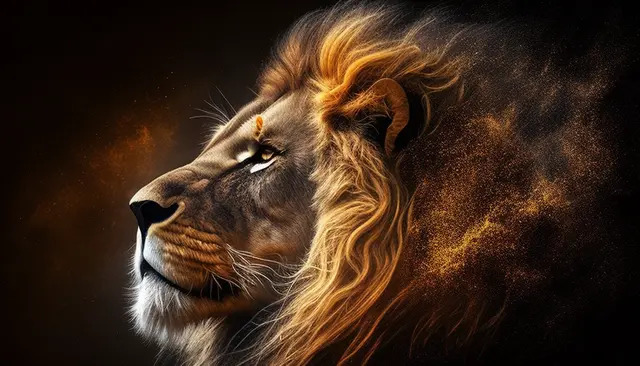

In [25]:
import PIL.Image

img = PIL.Image.open("image.jpg")
img

In [36]:
model = genai.GenerativeModel("gemini-1.5-flash")

In [43]:
import io

In [44]:
import google.generativeai as genai

# Assuming 'img' is your PIL.Image object
buffered = io.BytesIO()
img.save(buffered, format="JPEG")
file_info = genai.upload_file(buffered, mime_type="image/jpeg")

In [45]:
content = [
       {
           "role": "user",
           "parts": [
               {
                   "file_data": {
                       "mime_type": "image/jpeg",
                       "file_uri": file_info.uri  # Use the uploaded file's URI
                   }
               },
               {"text": "Describe this image"},
           ]
       }
   ]

In [46]:
model = genai.GenerativeModel('models/gemini-1.5-flash')
response1 = model.generate_content(content)
Markdown(response1.text)

That's a striking digital rendering of a lion's head and mane. 


Here's a breakdown of the image:

* **The Lion:** The lion is depicted in profile, its head turned slightly to the left. The focus is on the majesty of the animal. The mane is long, thick, and a rich blend of golden-brown and darker brown hues. The fur is meticulously detailed, suggesting a very soft and flowing texture.  The lion's expression is one of calm strength, perhaps even contemplation.

* **The Background:** The background is dark, almost black, which contrasts sharply with the lion's mane.  There's a subtle scattering of golden dust or sparkles that seems to emanate from the lion's mane and adds to the mystical feel. This effect draws the viewer's eye directly to the lion.

* **Overall Style:** The image's style is highly realistic but with artistic liberties taken to enhance the lion's beauty and power. The lighting is dramatic, highlighting the textures and contours of the lion's face and mane. The overall impression is one of power, nobility, and a touch of magic.


In [47]:
response = model.generate_content(
    [
        "Write a short, engaging blog post based on this picture. It should include a description of the Lion in the photo and talk about my hunting journey.",
        img,
    ],
    stream=True,
)
response.resolve()

In [48]:
Markdown(response.text)

## The King's Gaze: A Hunter's Reflection

The image above isn't just a picture; it's a memory etched in gold.  That magnificent lion, his amber mane catching the phantom light, embodies the raw power and untamed beauty I witnessed on my recent safari.  His gaze is intense, piercing, a testament to the majesty of the African plains.  His coat is a tapestry of browns and golds, each strand seemingly imbued with the dust of a thousand sunsets.  This king surveyed his kingdom, oblivious to my presence, a silent guardian of a land both breathtaking and brutally unforgiving.

My hunting journey wasn't about the kill; it was about the chase. It was about immersing myself in the heart of the wild, testing my limits, and confronting the primal forces of nature.  Days bled into nights, filled with the symphony of the savanna: the rustling of leaves, the distant call of a hyena, the thundering hooves of a distant herd. The hunt demanded patience, respect, and a deep understanding of the land and its inhabitants.  It was a humbling experience, a reminder of our place within the larger ecosystem.

While I didn’t take the life of this majestic creature (and honestly, who could?), I carried away something far more valuable: a profound connection to the wilderness and an unshakeable respect for the king of the jungle.  This image, this memory, is my trophy. A testament not to conquest, but to the awe-inspiring beauty and untamed spirit of the African wild.


In [49]:
model = genai.GenerativeModel("gemini-1.5-flash")
chat = model.start_chat(history=[])
chat

ChatSession(
    model=genai.GenerativeModel(
        model_name='models/gemini-1.5-flash',
        generation_config={},
        safety_settings={},
        tools=None,
        system_instruction=None,
        cached_content=None
    ),
    history=[]
)

In [50]:
response = chat.send_message(
    "In one sentence, explain how a Student in VIT Needs to Manage Stress given By Management."
)
Markdown(response.text)

VIT students should manage management-induced stress by prioritizing self-care, effective time management, seeking support from peers, counselors, or faculty, and advocating for reasonable workloads and policies.


In [51]:
chat.history

[parts {
   text: "In one sentence, explain how a Student in VIT Needs to Manage Stress given By Management."
 }
 role: "user",
 parts {
   text: "VIT students should manage management-induced stress by prioritizing self-care, effective time management, seeking support from peers, counselors, or faculty, and advocating for reasonable workloads and policies.\n"
 }
 role: "model"]

In [53]:
response = chat.send_message(
    "Okay, how about a more detailed explanation to a Research Scholar?", stream=True
)

for chunk in response:
    print(chunk.text)


Research
 scholars at VIT facing stress from management require a strategic approach encompassing several key areas.
  Firstly, **effective time management** is paramount. This goes beyond simple to
-do lists; it involves breaking down large projects into smaller, manageable tasks with clearly defined deadlines.  Prioritization techniques, such as Eisenhower Matrix, can help
 focus on high-impact activities.  Secondly, **proactive communication** with supervisors is vital. This shouldn't be reactive, addressing problems only when they
 arise, but rather a continuous dialogue about expectations, progress, and potential challenges.  Regular meetings to discuss progress and receive feedback are essential.  Thirdly, **self-care is non-negotiable**.  The demanding nature of research
 can easily lead to burnout.  Prioritizing sleep, regular exercise, a balanced diet, and mindful relaxation techniques (meditation, yoga) is crucial for maintaining both physical and mental well-being.  Fourthly

In [55]:
for message in chat.history:
    display(Markdown(f"**{message.role}**: {message.parts[0].text}"))

**user**: In one sentence, explain how a Student in VIT Needs to Manage Stress given By Management.

**model**: VIT students should manage management-induced stress by prioritizing self-care, effective time management, seeking support from peers, counselors, or faculty, and advocating for reasonable workloads and policies.


**user**: Okay, how about a more detailed explanation to a Research Scholar?

**model**: For research scholars at VIT facing stress stemming from management, a multifaceted approach is crucial.  This involves proactive time management techniques incorporating realistic deadlines and prioritization of tasks, coupled with robust self-care strategies such as regular exercise, sufficient sleep, and mindful practices to mitigate burnout.  Furthermore, effective communication with supervisors is vital, focusing on clear articulation of challenges, progress updates, and negotiating realistic expectations. Seeking mentorship from senior scholars and leveraging institutional support systems, including counseling services, is also recommended.  Finally,  developing healthy coping mechanisms, such as engaging in hobbies and maintaining a strong social support network, can significantly enhance resilience and overall well-being.


**user**: Okay, how about a more detailed explanation to a Research Scholar?

**model**: Research scholars at VIT facing stress from management require a strategic approach encompassing several key areas.  Firstly, **effective time management** is paramount. This goes beyond simple to-do lists; it involves breaking down large projects into smaller, manageable tasks with clearly defined deadlines.  Prioritization techniques, such as Eisenhower Matrix, can help focus on high-impact activities.  Secondly, **proactive communication** with supervisors is vital. This shouldn't be reactive, addressing problems only when they arise, but rather a continuous dialogue about expectations, progress, and potential challenges.  Regular meetings to discuss progress and receive feedback are essential.  Thirdly, **self-care is non-negotiable**.  The demanding nature of research can easily lead to burnout.  Prioritizing sleep, regular exercise, a balanced diet, and mindful relaxation techniques (meditation, yoga) is crucial for maintaining both physical and mental well-being.  Fourthly, **seeking support** is a sign of strength, not weakness.  Leveraging institutional resources like counseling services, mentorship programs, and peer support groups can provide valuable guidance and alleviate feelings of isolation.  Finally, **boundary setting** is critical.  While dedication is important,  it's equally crucial to establish healthy boundaries between work and personal life to prevent overwork and maintain a sustainable pace.  Regular reflection on progress and well-being, perhaps through journaling or self-assessment, can help identify areas for improvement and prevent escalating stress.


In [56]:
model.count_tokens(chat.history)

total_tokens: 517

In [59]:
prompt = input("Enter the Prompt :")
response = model.generate_content(prompt)
Markdown(response.text)

Enter the Prompt :Explain GPT ?


GPT stands for **Generative Pre-trained Transformer**.  It's a type of large language model (LLM) that uses deep learning to produce human-like text.  Let's break down each part:

* **Generative:**  This means GPT models can *generate* new text.  They don't just retrieve information; they create it based on the patterns and relationships they've learned from the vast amounts of text data they've been trained on.  They can write stories, answer questions, translate languages, and more.

* **Pre-trained:** Before GPT models can perform specific tasks, they undergo a pre-training phase. This involves feeding them a massive dataset of text and code, allowing them to learn the statistical relationships between words and phrases. This pre-training allows them to develop a general understanding of language, grammar, and facts.

* **Transformer:** This refers to the underlying architecture of the model.  Transformer networks are a type of neural network particularly well-suited for processing sequential data like text.  They use a mechanism called "self-attention" which allows the model to weigh the importance of different words in a sentence when generating text.  This allows for a much better understanding of context and relationships between words than older models.

In essence, GPT models are sophisticated pattern-recognition machines.  They've learned the statistical probabilities of different word sequences and can use this knowledge to generate remarkably coherent and contextually relevant text.  However, it's crucial to remember that they don't "understand" the text in the same way a human does; they're predicting the most likely next word based on their training data.  This can sometimes lead to outputs that are factually incorrect or nonsensical, despite appearing superficially plausible.  The larger the model (more parameters), the better it generally performs but also increases the computational resources needed.


In [60]:
from IPython.display import Markdown, display

while True:
    try:
        prompt = input("Enter the Prompt (or type 'exit' to quit): ")
        if prompt.lower() == "exit":
            print("Exiting the loop. Goodbye!")
            breakexi

        # Generate the response from the model
        response = model.generate_content(prompt)

        # Display the result as Markdown
        display(Markdown(response.text))

    except Exception as e:
        print(f"An error occurred: {e}")


Enter the Prompt (or type 'exit' to quit): Explain GPT ?


GPT stands for **Generative Pre-trained Transformer**.  It's a type of large language model (LLM) that uses deep learning to produce human-like text.  Let's break down each part:

* **Generative:** GPT models are generative, meaning they can create new text instead of just analyzing or summarizing existing text. They don't simply retrieve information; they generate it based on patterns learned from their training data.

* **Pre-trained:**  These models are "pre-trained" on massive datasets of text and code. This pre-training allows them to learn the statistical relationships between words, phrases, and sentences.  This vast knowledge base forms the foundation for their abilities.  Think of it like giving a child a huge library to read before they start school – they'll have a much broader understanding of language.

* **Transformer:**  The "Transformer" refers to the specific neural network architecture used.  Transformers are particularly good at understanding the context and relationships between words in a sentence, even those far apart. This is crucial for generating coherent and meaningful text.  They achieve this through a mechanism called "self-attention," which allows the model to weigh the importance of different words in a sentence when generating the next word.

In essence, GPT models work by predicting the next word in a sequence, based on the preceding words and the vast knowledge they've acquired during pre-training.  This process is repeated iteratively to generate longer and more complex texts.

Different versions of GPT exist, each with increasing size and capabilities (GPT-1, GPT-2, GPT-3, GPT-3.5, GPT-4, etc.).  The larger the model (meaning more parameters), the more data it's trained on, and generally the better its performance in generating high-quality, nuanced text.  These advancements have led to capabilities like:

* **Text generation:** Writing stories, articles, poems, code, etc.
* **Translation:** Converting text from one language to another.
* **Question answering:** Providing answers to complex questions.
* **Summarization:** Condensing large amounts of text into shorter summaries.
* **Chatbots:** Engaging in human-like conversations.

It's important to note that while GPT models are incredibly powerful, they are not perfect. They can sometimes generate incorrect or nonsensical information, exhibit biases present in their training data, and lack genuine understanding of the world.  They are tools that should be used responsibly and critically evaluated.


Enter the Prompt (or type 'exit' to quit): Explain about Ashik ?


"Ashik" (آشیق) refers to a **traveling minstrel** or **folk musician** traditionally found in Azerbaijan, Turkey, and other parts of the Caucasus and Anatolia.  It's more than just a musician, though; the Ashik represents a unique cultural tradition combining music, poetry, and storytelling.

Here's a breakdown of key aspects of the Ashik tradition:

* **Music and Instruments:** Ashiks typically play the *saz*, a long-necked lute with a pear-shaped body.  The saz is central to their performances and is often intricately decorated.  Their music is characterized by modal scales and improvisational elements.

* **Poetry and Storytelling:** Ashiks are often accomplished poets, composing and reciting their own verses, called *dastans*. These dastans are epic poems that tell stories of love, heroism, history, and social commentary.  They might be sung solo or accompanied by the saz.  The storytelling aspect is crucial; the Ashik is not just a singer, but a narrator weaving a tale through music and words.

* **Improvisation:**  A significant part of Ashik performances involves improvisation.  Ashiks often respond to the audience, incorporating their requests or adapting their performance based on the atmosphere.

* **Social Role:** Traditionally, Ashiks played an important social role, travelling from village to village, performing at gatherings, weddings, and other events. They were both entertainers and storytellers, acting as a link between communities and preserving oral traditions.

* **Modern Ashiks:**  While the tradition has faced challenges with the rise of modern media, Ashiks continue to perform and the tradition is still alive. Efforts are being made to preserve and promote this unique cultural heritage.  There are even Ashik schools and festivals that help sustain and teach the art form to new generations.

In short, the Ashik is much more than just a musician.  They are a vital part of their culture, acting as keepers of history, storytellers, and entertainers, all wrapped into one captivating performance style.  Their music and poetry reflect the rich cultural tapestry of the regions where they thrive.


Enter the Prompt (or type 'exit' to quit): exit
Exiting the loop. Goodbye!
